In [1]:
import numpy as np
import pandas as pd
import random as rng
import datetime as dt
from datetime import timedelta
import requests
%matplotlib inline
import gplearn
from gplearn.genetic import SymbolicTransformer
import matplotlib.pyplot as plt
import numpy as np
import graphviz
from scipy.stats import pearsonr
from sklearn.decomposition import PCA

In [2]:
api_key = ''
polygon_data = api_key

response = requests.get(f"{polygon_data}")
polygon_data = response.json()

result_bars = polygon_data['results'] # this is a dictionary

aggregate_bars = pd.DataFrame()

# we are turning this dictionary into a pnadas dataframe to make it easier to use 
for bar in result_bars:
    #we have to convert the unix milliseconds to seconds before we do anything
    time = (bar['t']) / 1000.0
    new_row = {'Date': dt.datetime.utcfromtimestamp(time), 
               'Close': bar['c'], 
               'Open': bar['o'],
               'High': bar['h'], 
               'Low': bar['l'], 
               'Volume': bar['v'], 
               'VWAP': bar['vw'], 
               'Returns': bar['c']- bar['o']}
    aggregate_bars = aggregate_bars._append(new_row, ignore_index=True)

aggregate_bars.set_index('Date', inplace=True)
aggregate_bars.index = pd.to_datetime(aggregate_bars.index)
aggregate_bars.index = aggregate_bars.index.date

In [3]:
def stock_return(stock_data, holding_period, date):
    
    '''
    We are returning 'r', which is a vector that n columns long, 
    with each column corresponding to a different asset/stock, 
    with the value at each column being the return value over a specfic holding period 'h' 
    '''
    
    closets = stock_data.loc[date, 'Close']
    if (date + timedelta(days=holding_period)) in stock_data.index:
        closeths = stock_data.loc[(date + timedelta(days=holding_period)), 'Close']
    else: 
        in_store = -1
        while in_store == -1:
            holding_period = holding_period + 1
            if (date + timedelta(days=holding_period)) in stock_data.index:
                closeths = stock_data.loc[(date + timedelta(days=holding_period)), 'Close']
                in_store = 1
            else:
                continue

    # return for that holding period = (closeths - closets) / closets
    stock_return = (closeths - closets) / closets
    return stock_return

In [4]:
hp_1_returns = []

last_index = aggregate_bars.index[-1]

for index, row in aggregate_bars.iterrows():
    if index == last_index:
        hp_1_returns.append(0.5)
        continue
    else:
        hp_1_returns.append(stock_return(aggregate_bars, 1, index))
        
aggregate_bars['hp_1_returns'] = hp_1_returns

In [5]:
features = ['Returns', 'Close', 'Open', 'High', 'Low', 'Volume', 'VWAP']
target = ['hp_1_returns']
X_train = aggregate_bars[features].values
y_train = aggregate_bars[target].values.flatten()

Step 1

We enumerate the alphas of depth 1 and select the effective
ones to set up the gene pool.

In [6]:
function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min']

est_gp = SymbolicTransformer(generations=20, population_size=5000,
                         init_depth =(1,1), 
                         hall_of_fame=50, n_components=10,
                         stopping_criteria=0.6,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=39, n_jobs=3,
                         metric="pearson")
est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


   0     2.54         0.021928        2         0.156767          0.22921     47.74s
   1     2.63        0.0319348        3          0.15421         0.392316     47.67s
   2     2.63        0.0365094        3         0.184105         0.255417     42.93s
   3     2.80        0.0418789        4         0.271837           0.1494     41.87s
   4     3.37         0.058017        7         0.315934        0.0241376     38.64s
   5     4.69        0.0914609       12         0.850164          0.16073     37.87s


SymbolicTransformer(function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'abs', 'neg', 'inv', 'max', 'min'],
                    hall_of_fame=50, init_depth=(1, 1), max_samples=0.9,
                    n_jobs=3, parsimony_coefficient=0.0005,
                    population_size=5000, random_state=39,
                    stopping_criteria=0.6, verbose=1)

Step 2

We use the warm start method and the gene pool to initialize the population of depth 2. Then we use crossover and the replacement method for reproduction. If the new offspring has higher IC than its parents, we will calculate
its PCA-similarity with the alphas in the record and determine whether to keep it in the population

In [7]:
est_gp.set_params(generations=20, population_size=5000,
                         init_depth =(2,2), warm_start=True, 
                         hall_of_fame=50, n_components=10,
                         stopping_criteria=0.7,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=39, n_jobs=3,
                         metric="pearson")
est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   6     5.82         0.121847        9         0.897377        0.0872716     34.39s


SymbolicTransformer(function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'abs', 'neg', 'inv', 'max', 'min'],
                    hall_of_fame=50, init_depth=(2, 2), max_samples=0.9,
                    n_jobs=3, parsimony_coefficient=0.0005,
                    population_size=5000, random_state=39,
                    stopping_criteria=0.7, verbose=1, warm_start=True)

Step 3

We repeat step 2 for more alphas of depth 2 and update
the gene pool and the record. Then we can start generating
alphas of depth 3 and so forth

In [8]:
est_gp.set_params(generations=20, population_size=5000,
                         init_depth =(3,3), warm_start=True, 
                         hall_of_fame=50, n_components=10,
                         stopping_criteria=0.8,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=39, n_jobs=3,
                         metric="pearson")
est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   7     6.83         0.171706       16          0.91333         0.129238     33.43s


SymbolicTransformer(function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'abs', 'neg', 'inv', 'max', 'min'],
                    hall_of_fame=50, init_depth=(3, 3), max_samples=0.9,
                    n_jobs=3, parsimony_coefficient=0.0005,
                    population_size=5000, random_state=39,
                    stopping_criteria=0.8, verbose=1, warm_start=True)

0.9133300316194426


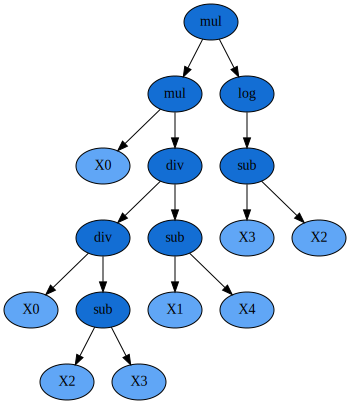

In [9]:
print(est_gp._best_programs[0].raw_fitness_)
dot_data = est_gp._best_programs[0].export_graphviz()
graph = graphviz.Source(dot_data)
graph

Here's the problem using gplearn: 

A lot of the operators mentioned in the '101 Alpha's Paper' require the variable 'd', which represents days before/after the input x. 

Gplearn does not allow 'array' inputs that store the date prior/afer day x. 

Therefore, I can't really calculate accurate formulas.

But nevertheless...

THESE ARE ALPHAS!!!!!

Nice job man you actually created an alpha. Time to keep reading. 